In [314]:
import sklearn
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.07, random_state=42)

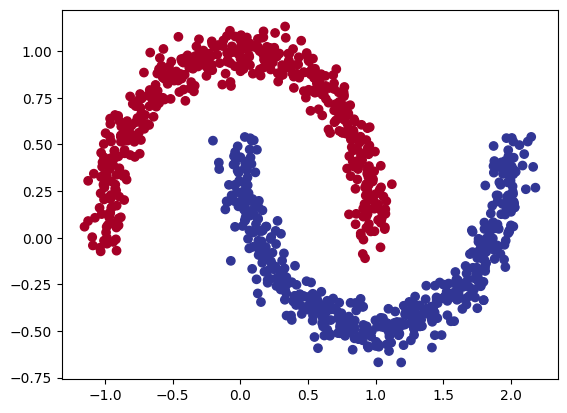

In [315]:
import torch
import helper_functions
from helper_functions import *

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

#plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [316]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [317]:
from torch import nn

class CrescentModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=2)
            )
    
    def forward(self, x):
        return self.layers(x)

In [318]:
torch.manual_seed(42)
device = "cuda"
model = CrescentModel().to(device)
model

CrescentModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [319]:
model.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layers.0.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layers.2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.

In [320]:


loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.1)

In [321]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

print("Logits: ")
print(model(X_train[:10]))

Logits: 
tensor([[0.2097, 0.0182],
        [0.2173, 0.0320],
        [0.2239, 0.0396],
        [0.2264, 0.0409],
        [0.2362, 0.0303],
        [0.2270, 0.0409],
        [0.2370, 0.0289],
        [0.2274, 0.0260],
        [0.2337, 0.0446],
        [0.2157, 0.0260]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [322]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


MulticlassAccuracy()

In [323]:
torch.manual_seed(42)

epochs=1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model.train()

  # 1. Forward pass
  y_logits = model(X_train)
  # print(y_logits[:5]) # model raw outputs are "logits"
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimiser.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
  optimiser.step()

  ### Testing
  model.eval() 
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int()) 

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")



# epochs = 100

# for epoch in range(epochs):
#     model.train()

#     y_logits = model(X_train)
#     y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
#     acc = accuracy_fn(y_true=y_train,
#                       y_pred=y_pred)
#     loss = loss_fn(y_logits, y_train)
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()

#     model.eval()
#     with torch.inference_mode():
#         test_logits = model(X_test)
#         test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
#         test_loss = loss_fn(test_logits, y_test)
#         test_acc = accuracy_fn(y_true=y_test,
#                              y_pred=test_pred)

#     # Print out what's happening
#     if epoch % 10 == 0:
#         print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70 Acc: 0.50 | Test loss: 0.70 Test acc: 0.50
Epoch: 100 | Loss: 0.43 Acc: 0.82 | Test loss: 0.44 Test acc: 0.79
Epoch: 200 | Loss: 0.23 Acc: 0.89 | Test loss: 0.23 Test acc: 0.93
Epoch: 300 | Loss: 0.17 Acc: 0.93 | Test loss: 0.16 Test acc: 0.95
Epoch: 400 | Loss: 0.12 Acc: 0.95 | Test loss: 0.10 Test acc: 0.97
Epoch: 500 | Loss: 0.07 Acc: 0.98 | Test loss: 0.06 Test acc: 1.00
Epoch: 600 | Loss: 0.05 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 700 | Loss: 0.03 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00


In [324]:
X_train[:5], y_train[:5]

(tensor([[ 2.0144,  0.2466],
         [-1.0187,  0.4045],
         [-0.1252,  1.0580],
         [-0.0977,  0.9901],
         [ 0.3807, -0.2384]], device='cuda:0'),
 tensor([1, 0, 0, 0, 1], device='cuda:0'))

In [325]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # ------------------- MODIFIED SECTION ------------------- #
    # Test for multi-class or binary and adjust logits to prediction labels
    # This logic now works for binary classification models with 2 output features
    if len(y_logits.shape) > 1 and y_logits.shape[1] > 1:
        # For multi-class or binary models with >1 output neuron
        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    else:
        # For binary models with 1 output neuron
        y_pred = torch.round(torch.sigmoid(y_logits))
    # -------------------------------------------------------- #

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

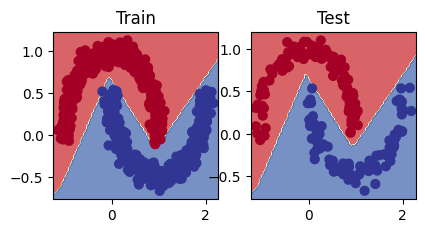

In [326]:
plt.figure(figsize=(20, 10))
plt.subplot(4, 8, 1)
plt.title("Train")
decision_boundary(model, X_train, y_train)
plt.subplot(4, 8, 2)
plt.title("Test")
decision_boundary(model, X_test, y_test)

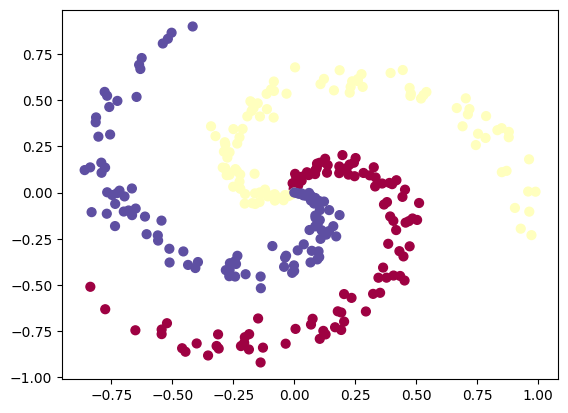

In [327]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [328]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [329]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2)

In [330]:
device = "cuda"

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [331]:
from torch import nn

class Spiral(nn.Module):
    def __init__(self, input=2, output=3, hidden_features=10):
        super().__init__()

        self.layers = nn.Sequential(nn.Linear(in_features=input, out_features=hidden_features),
                                    nn.ReLU(),
                                    nn.Linear(in_features=hidden_features, out_features=hidden_features),
                                    nn.ReLU(),
                                    nn.Linear(in_features=hidden_features, out_features=output))
        
    def forward(self, x):
        return self.layers(x)

In [332]:
model = Spiral(hidden_features=50).to(device)
model.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
 

In [333]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.12, momentum=0.9)

In [334]:
model(X_train[:10])

tensor([[-0.0293,  0.1143, -0.0261],
        [-0.0644,  0.1287, -0.0042],
        [-0.0739,  0.1131,  0.0007],
        [-0.0825,  0.1193,  0.0074],
        [-0.1053,  0.1030,  0.0123],
        [-0.0392,  0.1322, -0.0261],
        [-0.0816,  0.1198,  0.0019],
        [-0.0875,  0.1218,  0.0072],
        [-0.0619,  0.1297, -0.0056],
        [-0.0918,  0.1112,  0.0144]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [335]:
epochs = 250

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train.int())
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test.int())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.10683, Acc: 0.30% | Test Loss: 1.09598, Test Acc: 0.34%
Epoch: 10 | Loss: 0.99114, Acc: 0.47% | Test Loss: 1.02278, Test Acc: 0.47%
Epoch: 20 | Loss: 0.78233, Acc: 0.65% | Test Loss: 0.84491, Test Acc: 0.53%
Epoch: 30 | Loss: 0.66781, Acc: 0.62% | Test Loss: 0.71386, Test Acc: 0.59%
Epoch: 40 | Loss: 0.58311, Acc: 0.62% | Test Loss: 0.62346, Test Acc: 0.65%
Epoch: 50 | Loss: 0.46554, Acc: 0.72% | Test Loss: 0.52101, Test Acc: 0.73%
Epoch: 60 | Loss: 0.31999, Acc: 0.92% | Test Loss: 0.40549, Test Acc: 0.83%
Epoch: 70 | Loss: 0.20733, Acc: 0.93% | Test Loss: 0.32718, Test Acc: 0.87%
Epoch: 80 | Loss: 0.14506, Acc: 0.95% | Test Loss: 0.28619, Test Acc: 0.90%
Epoch: 90 | Loss: 0.11051, Acc: 0.97% | Test Loss: 0.26426, Test Acc: 0.92%
Epoch: 100 | Loss: 0.08915, Acc: 0.98% | Test Loss: 0.25881, Test Acc: 0.93%
Epoch: 110 | Loss: 0.07439, Acc: 0.98% | Test Loss: 0.26120, Test Acc: 0.92%
Epoch: 120 | Loss: 0.06367, Acc: 0.98% | Test Loss: 0.26186, Test Acc: 0.93%
Epoch: 130

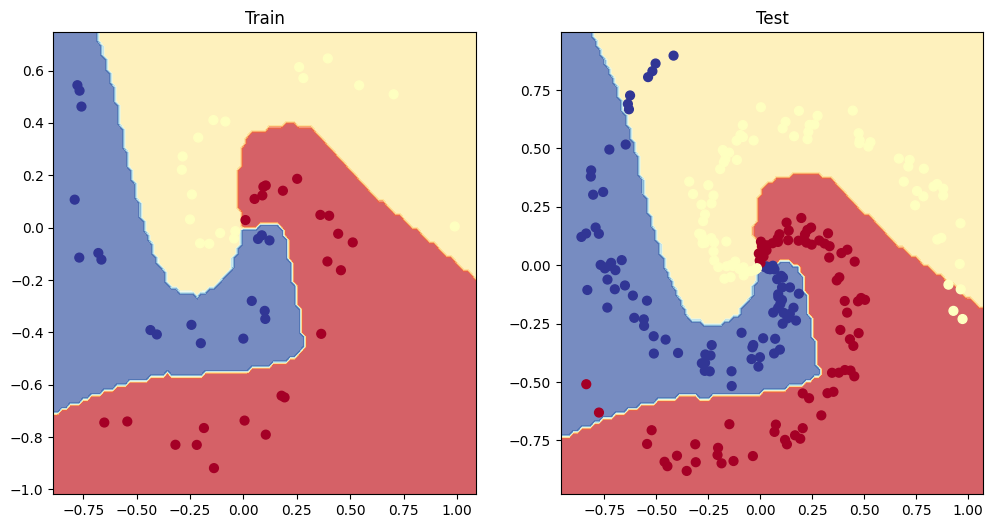

In [336]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)